In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime, timedelta, date
from configparser import SectionProxy
from logging import Logger
import logging

from typing import Mapping, Optional, Dict, List, Tuple

link = 'https://andelenergi.dk/?obexport_format=csv&obexport_start=2022-08-10&obexport_end=2022-08-18&obexport_region=east'

region = 'east'
transport_overhead = 1.59 #DKK

logger = logging.getLogger(__name__)
logger.info('Getting price data')

def make_El_price_URL(start_date: date, end_date: date, region: str) -> str:
    url = 'https://andelenergi.dk/?obexport_format=csv&obexport_start='+str(start_date)+'&obexport_end='+str(end_date)+'&obexport_region='+region
    return url

def get_price_csv(start_date, end_date, region):
    url = make_El_price_URL(start_date, end_date, region)
    try:
        el_data = pd.read_csv(url, decimal=',')
    except Exception as e:
        logger.exception('Error getting price data from: %s', url)
        return None
    el_data.Date = pd.to_datetime(el_data.Date)#.dt.date
    el_data2 = el_data.set_index('Date')
    el_data2.columns = pd.to_datetime(el_data2.columns)
    el_data2_st = el_data2.stack()
    dates = el_data2_st.index.get_level_values(0) 
    times = el_data2_st.index.get_level_values(1) 
    times.to_pydatetime()

    df = pd.DataFrame(columns= ['Date', 'Time', 'Datetime','Price'])
    df['Date'] = dates.date.astype(str)
    df['Time'] = times.time.astype(str)
    df['Hour'] = times.hour.astype(str)
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' +df['Time'])
    df['Price'] = el_data2_st.values+transport_overhead
    df['Weekday'] = df['Datetime'].dt.day_name()
    df['Weekday'] = df['Weekday'].str.slice(0, 3)
    df['WeekHour'] = df['Weekday']+df['Hour']

    El_data = df[df['Datetime']>str(datetime.now())]
    #El_data = df[df['Datetime']>'09:00:00 2022-08-23']
    El_data.reset_index(drop=True,inplace=True)
    return El_data

now = datetime.today()
El_data = get_price_csv(now.date(), now.date()+timedelta(days=1), region)

print(El_data)

          Date      Time            Datetime  Price Hour Weekday WeekHour
0   2022-08-24  00:00:00 2022-08-24 00:00:00  7.001    0     Wed     Wed0
1   2022-08-24  01:00:00 2022-08-24 01:00:00  6.705    1     Wed     Wed1
2   2022-08-24  02:00:00 2022-08-24 02:00:00  6.707    2     Wed     Wed2
3   2022-08-24  03:00:00 2022-08-24 03:00:00  6.575    3     Wed     Wed3
4   2022-08-24  04:00:00 2022-08-24 04:00:00  6.603    4     Wed     Wed4
5   2022-08-24  05:00:00 2022-08-24 05:00:00  6.930    5     Wed     Wed5
6   2022-08-24  06:00:00 2022-08-24 06:00:00  7.616    6     Wed     Wed6
7   2022-08-24  07:00:00 2022-08-24 07:00:00  7.944    7     Wed     Wed7
8   2022-08-24  08:00:00 2022-08-24 08:00:00  8.046    8     Wed     Wed8
9   2022-08-24  09:00:00 2022-08-24 09:00:00  7.634    9     Wed     Wed9
10  2022-08-24  10:00:00 2022-08-24 10:00:00  7.059   10     Wed    Wed10
11  2022-08-24  11:00:00 2022-08-24 11:00:00  6.955   11     Wed    Wed11
12  2022-08-24  12:00:00 2022-08-24 12

0


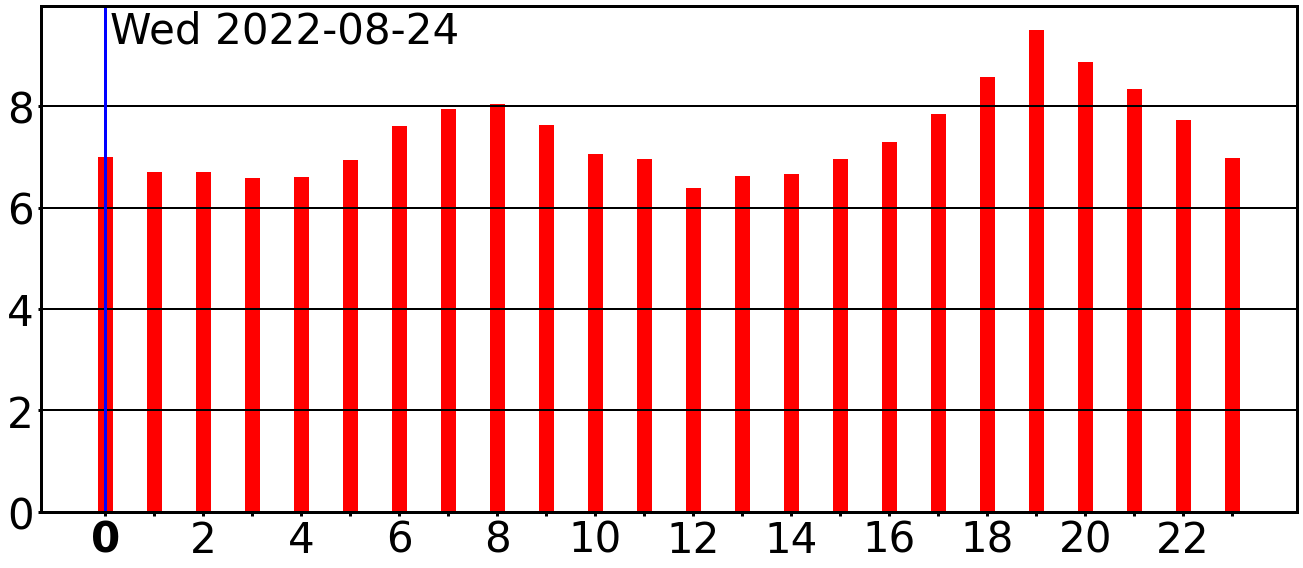

In [5]:
%matplotlib inline
import io
from PIL import Image
import utils
import configparser

CONFIG_FILENAME = 'config.ini'

with open(CONFIG_FILENAME) as f:
    config_parser = configparser.ConfigParser()
    config_parser.read_file(f)
    logger.info('Config: %s', config_parser.items('general'))
    config = config_parser['general']
    fonts = utils.get_fonts(config)

vsize = 448-200
hsize = 600
dpi = 80
factor=3

fig = plt.figure(figsize=((hsize/dpi*factor,vsize/dpi*factor)), frameon=False)
ax = plt.subplot()
vals = El_data.Price
hours = El_data.WeekHour
colors = ["green" if i < 3 else "red" for i in vals]
barplot = ax.bar(El_data.WeekHour, El_data.Price, 0.3, color=colors)
#ax.set_xlim([El_data.Hour[0], El_data.Hour[-1]])
ax.set_xticks(hours)
ax.set_xticklabels(El_data.Hour)
ax.grid(axis='y', linewidth=2, color='k')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

# increase tick width
ax.tick_params(width=3)

for i, tick in enumerate(ax.get_xticklabels()):
    tick.set_fontname('barlow-condensed')
    tick.set_fontsize(14*factor)
    if tick.get_text() == '0' or tick.get_text() == '1':
        tick.set_fontweight(weight="bold")
for tick in ax.get_xticklabels()[1::2]:
    tick.set_visible(False)
for tick in ax.get_yticklabels():
    tick.set_fontname('barlow-condensed')
    tick.set_fontsize(14*factor)

if '0' in El_data.Hour.values:
    ind = El_data.index[El_data['Hour'] == '0'][0]
    print(ind)
    ax.axvline(x = ind, color = 'b', linewidth = 3, label = 'axvline - full height')
    if ind>0:
        ax.text(ind.astype(float)-0.1, 
                np.max(vals), 
                El_data.Weekday.iloc[ind-1], 
                horizontalalignment='right', 
                verticalalignment='center',
                fontname='barlow-condensed',
                fontsize = 14*factor)
    ax.text(ind.astype(float)+0.1, 
             np.max(vals), 
             El_data.Weekday.iloc[ind]+' '+El_data.Date.iloc[ind], 
             horizontalalignment='left', 
             verticalalignment='center',
             fontname='barlow-condensed',
             fontsize = 14*factor)
plt.show()



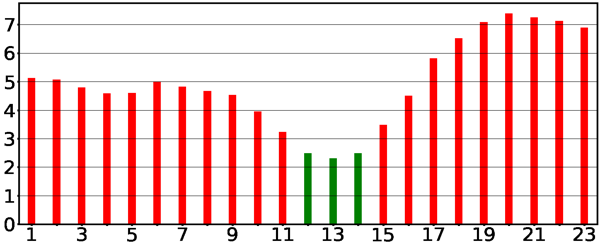

In [118]:
buf = io.BytesIO()

fig.savefig(buf, format="png", dpi=dpi,bbox_inches='tight')
fig.savefig('elpanel_plot.png', format="png", dpi=dpi)
buf.seek(0)
plot_image = Image.open(buf).convert("RGB")
newsize = (hsize, vsize)
im1 = plot_image.resize(newsize)
display(im1)
buf.close()

In [44]:
print(ind[0].astype(int))

ax.text(ind[0].astype(float)+0.5, 
             np.max(vals), 
             'Wed', 
             horizontalalignment='center', 
             verticalalignment='center')

1


Text(1.5, 9.494, 'Wed')

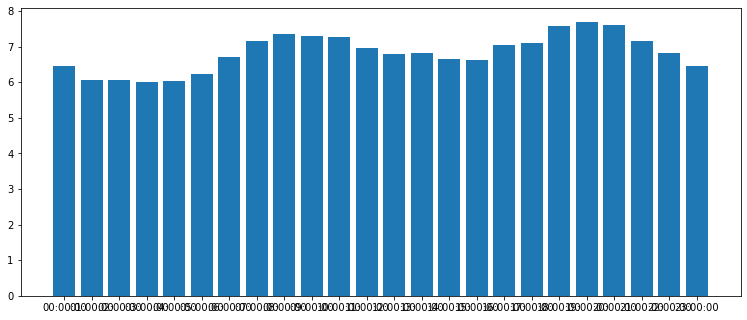

In [196]:
fig = plt.figure(figsize=[10,4])
ax = fig.add_axes([0,0,1,1])
ax.bar(El_data.Time,El_data.Price)
plt.show()